In [1]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile


2024-12-06 12:05:18.355121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/vl/ffnrmcms5mx5g1pss893jh0r0000gn/T/ipykernel_68809/2002171943.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [2]:
import cv2
import os
import random
from tqdm import tqdm

# Paths to the image folders
H6_folder = 'Defungi/H6'
H1_folder = 'Defungi/H1'

# Variables to store images and labels
X_H6 = []
y_H6 = []
X_H1 = []
y_H1 = []

# Process the H6 folder
if os.path.exists(H6_folder):
    print("Processing H6 folder...")
    for i in tqdm(os.listdir(H6_folder)):
        img_path = os.path.join(H6_folder, i)  # Construct full path
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize all images to 224x224
        X_H6.append(img)
        y_H6.append('H6')  # Label as 'H6'
else:
    print(f"Folder not found: {H6_folder}")

# Process the White folder
if os.path.exists(H1_folder):
    print("Processing White folder...")
    for i in tqdm(os.listdir(H1_folder)):
        img_path = os.path.join(H1_folder, i)  # Construct full path
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize all images to 224x224
        X_H1.append(img)
        y_H1.append('H1')  # Label as 'H1'
else:
    print(f"Folder not found: {H1_folder}")


if len(X_H6) >= 100 and len(X_H1) >= 100:
    cat_sample_indices = random.sample(range(len(X_H6)), 400)
    dog_sample_indices = random.sample(range(len(X_H1)), 400)

    X_cat_sample = [X_H6[i] for i in cat_sample_indices]
    y_cat_sample = [y_H6[i] for i in cat_sample_indices]

    X_dog_sample = [X_H1[i] for i in dog_sample_indices]
    y_dog_sample = [y_H1[i] for i in dog_sample_indices]

    samples = list(zip(X_cat_sample + X_dog_sample, y_cat_sample + y_dog_sample))

    # Shuffle the combined list
    random.shuffle(samples)

    # Unzip the shuffled list back into X_sample_train and y_sample_train
    X_sample_train, y_sample_train = zip(*samples)

    # Convert back to lists if needed
    X_sample_train = list(X_sample_train)
    y_sample_train = list(y_sample_train)

    # Debugging: Verify labels
    print(f"Final labels: {np.unique(y_sample_train)}")
else:
    print("Not enough images: need at least 400 cats and 800 dogs.")


Processing H6 folder...


100%|██████████| 739/739 [00:01<00:00, 418.98it/s]


Processing White folder...


100%|██████████| 4404/4404 [00:10<00:00, 413.54it/s]

Final labels: ['H1' 'H6']


In [3]:

if len(X_H6) >= 100 and len(X_H1) >= 100:
    cat_sample_indices = random.sample(range(len(X_H6)), 400)
    dog_sample_indices = random.sample(range(len(X_H1)), 400)

    X_cat_sample = [X_H6[i] for i in cat_sample_indices]
    y_cat_sample = [y_H6[i] for i in cat_sample_indices]

    X_dog_sample = [X_H1[i] for i in dog_sample_indices]
    y_dog_sample = [y_H1[i] for i in dog_sample_indices]

    samples = list(zip(X_cat_sample + X_dog_sample, y_cat_sample + y_dog_sample))

    # Shuffle the combined list
    random.shuffle(samples)

    # Unzip the shuffled list back into X_sample_train and y_sample_train
    X_sample_test, y_sample_test = zip(*samples)

    # Convert back to lists if needed
    X_sample_test = list(X_sample_test)
    y_sample_test = list(y_sample_test)

    # Debugging: Verify labels
    print(f"Final labels: {np.unique(y_sample_test)}")
else:
    print("Not enough images: need at least 400 cats and 800 dogs.")

Final labels: ['H1' 'H6']


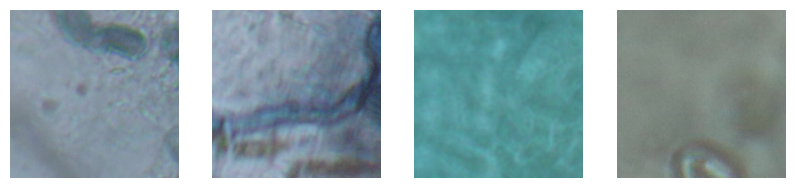

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_sample_train[i], cmap="gray")
    plt.axis('off')
plt.show()

In [5]:
print(f"Number of images in X: {len(X_sample_train)}")
print(f"Number of labels in y: {len(y_sample_train)}")
print(f"Number of images in X: {len(X_sample_test)}")
print(f"Number of labels in y: {len(y_sample_test)}")

Number of images in X: 800
Number of labels in y: 800
Number of images in X: 800
Number of labels in y: 800


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg_model.output
x = Flatten()(x) 
x = Dense(4096, activation='relu')(x)
model_with_fc = Model(inputs=vgg_model.input, outputs=x)

print(model_with_fc.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,479,232 (448.15 MB)

 Trainable params: 117,479,232 (448.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


X_sample_train_processed = []

for img in X_sample_train:
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    X_sample_train_processed.append(img_array)

X_sample_train_processed = np.vstack(X_sample_train_processed)

batch_size = 32
X_train_features = model_with_fc.predict(X_sample_train_processed, batch_size=batch_size)

print(f"Extracted training features shape: {X_train_features.shape}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step
Extracted training features shape: (800, 4096)


In [8]:
X_sample_test_processed = []

for img in X_sample_test:
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    X_sample_test_processed.append(img_array)

X_sample_test_processed = np.vstack(X_sample_test_processed)

X_test_features = model_with_fc.predict(X_sample_test_processed)

print(f"Extracted training features shape: {X_test_features.shape}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step
Extracted training features shape: (800, 4096)


In [9]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_sample_train)
y_test = le.fit_transform(y_sample_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train_features)
y_test = np.array(y_test)
X_test = np.array(X_test_features) 

In [10]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (800, 4096)
X_test Shape:  (800, 4096)
y_train Shape:  (800, 2)
y_test Shape:  (800, 2)


In [11]:
y_train = np.array([1 if label[0] == 1 else -1 for label in y_train], dtype=np.int32)
y_test = np.array([1 if label[0] == 1 else -1 for label in y_test], dtype=np.int32)


print(f"Converted y_train: {y_train[:10]}")
print(f"Unique values in y_train_converted: {np.unique(y_train)}")
print(f"Converted y_train: {y_test[:10]}")
print(f"Unique values in y_train_converted: {np.unique(y_test)}")



Converted y_train: [-1 -1 -1  1 -1  1 -1  1  1 -1]
Unique values in y_train_converted: [-1  1]
Converted y_train: [-1  1  1 -1 -1 -1 -1 -1 -1  1]
Unique values in y_train_converted: [-1  1]


In [12]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Soft-margin SVM using CVXPY
def soft_margin_svm(X, y, C):
    """
    Solves the soft-margin SVM problem using CVXPY
    Args:
    - X: Data matrix of shape (m, n) where m is the number of points and n is the dimension (features).
    - y: Labels vector of shape (m,) with entries in {-1, 1}.
    - C: Regularization parameter.
    Returns:
    - b: Coefficient vector of shape (n,)
    - c: Intercept (scalar)
    - xi: Slack variables vector of shape (m,)
    """
    m, n = X.shape

    # Define the variables
    b = cp.Variable(n)    # weight vector
    c = cp.Variable()     # bias
    xi = cp.Variable(m)   # slack variables

    # Define the objective function: minimize (1/2) * ||b||^2 + C * sum(xi)
    objective = cp.Minimize(0.5 * cp.sum_squares(b) + C * cp.sum(xi))

    # Define the constraints: y_i * (b^T x_i + c) >= 1 - xi_i, xi_i >= 0
    constraints = [y[i] * (X[i] @ b + c) >= 1 - xi[i] for i in range(m)]
    constraints += [xi >= 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Return the solution: b, c, and xi
    return b.value, c.value, xi.value

# Function to predict using the learned SVM model
def predict(X, b, c):
    return np.sign(X @ b + c)


In [13]:
from sklearn.metrics import accuracy_score, classification_report
# Run the SVM (Soft-margin SVM)
C = 1.0  # Regularization parameter
b_opt, c_opt, xi_opt = soft_margin_svm(X_train, y_train, C)

# Predict the labels on the test set
y_pred = predict(X_test, b_opt, c_opt)

# Compute accuracy and display classification report
accuracy = accuracy_score(y_test, y_pred)

print(f"Testing Accuracy: {accuracy * 100:.2f}%")

print("Classification Report for Testing Set:")
print(classification_report(y_test, y_pred))

Testing Accuracy: 96.62%
Classification Report for Testing Set:
              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       400
           1       0.96      0.97      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [14]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

def tsvm(A, B, C1=1.0, C2=1.0):
    """
    TSVM

    Args:
    - A: Matrix of points for class 1 (positive class).
    - B: Matrix of points for class -1 (negative class).
    - n_universum: Number of Universum points to generate.
    - C1: Regularization parameter for class 1.
    - C2: Regularization parameter for class -1.

    Returns:
    - b1_opt, c1_opt: Optimal weight vector and bias for class 1 hyperplane.
    - b2_opt, c2_opt: Optimal weight vector and bias for class -1 hyperplane.
    """

    n_class1, n_features = A.shape
    n_class_minus_1 = B.shape[0]



    # Optimization variables for Class 1
    b1 = cp.Variable(n_features)
    c1 = cp.Variable()
    xi1 = cp.Variable(n_class_minus_1)  # Slack variables for class -1 constraints
    
    # Optimization variables for Class 2
    b2 = cp.Variable(n_features)
    c2 = cp.Variable()
    xi2 = cp.Variable(n_class1)  # Slack variables for class 1 constraints
  

    # Objective function for Class 1
    objective1 = cp.Minimize(0.5 * cp.norm(A @ b1 + c1, 2)**2 + C1 * cp.sum(xi1))

    # Constraints for Class 1
    constraints1 = [
        -B @ b1 - c1 + xi1 >= np.ones(n_class_minus_1),
        xi1 >= 0  # Class -1 points
    ]

    # Solve for Class 1
    problem1 = cp.Problem(objective1, constraints1)
    problem1.solve()
    b1_opt = b1.value
    c1_opt = c1.value

    # Objective function for Class 2
    objective2 = cp.Minimize(0.5 * cp.norm(B @ b2 + c2, 2)**2 + C2 * cp.sum(xi2))

    # Constraints for Class 2
    constraints2 = [
        A @ b2 + c2 + xi2 >= np.ones(n_class1),
        xi2 >= 0   # Class 1 points
    ]

    # Solve for Class 2
    problem2 = cp.Problem(objective2, constraints2)
    problem2.solve()
    b2_opt = b2.value
    c2_opt = c2.value

    return b1_opt, c1_opt, b2_opt, c2_opt

def predict(X, b1_opt, c1_opt, b2_opt, c2_opt):
    """
    Predicts the labels for the given data points using TSVM with learned hyperplanes.

    Args:
    - X: Input data points, shape (n_samples, n_features).
    - b1_opt: Optimal weight vector for class 1 hyperplane.
    - c1_opt: Optimal bias for class 1 hyperplane.
    - b2_opt: Optimal weight vector for class -1 hyperplane.
    - c2_opt: Optimal bias for class -1 hyperplane.

    Returns:
    - y_pred: Predicted labels for the data points, +1 or -1.
    """
    # Calculate distance from hyperplane 1 (class +1)
    distance_to_class1 = np.abs(np.dot(X, b1_opt) + c1_opt)
    
    # Calculate distance from hyperplane 2 (class -1)
    distance_to_class2 = np.abs(np.dot(X, b2_opt) + c2_opt)
    
    # Assign label based on which hyperplane is closer
    y_pred = np.where(distance_to_class1 < distance_to_class2, 1, -1)
    
    return y_pred

In [15]:
A = X_train[y_train == 1]  
B = X_train[y_train == -1]

In [16]:
# TSVM
b1_opt, c1_opt, b2_opt, c2_opt  = tsvm(
    A, B, C1=1.0, C2=1.0)

# Predict on the train data
y_pred = predict(X_test, b1_opt, c1_opt, b2_opt, c2_opt)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 96.00%
Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.97      0.96       400
           1       0.97      0.95      0.96       400

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin

class QSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, mu=0.2):
        self.mu = mu

    def fit(self, X, y):
        self.d = self._calculate_d(X.shape[1])  # Calculate dimensionality once
        G, r = self.compute_G_and_r(X)
        self.z, self.c = self.optimize_z_c(G, r, y, self.mu)
        return self  # Return self instead of z and c

    def predict(self, X):
        r = self._compute_r_matrix(X)
        return np.sign(r @ self.z + self.c)

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def compute_G_and_r(self, X):
        """Compute the matrices G and r based on X."""
        m, n = X.shape
        G = np.zeros((self.d, self.d))
        r = np.zeros((m, self.d))
        D_n = self.get_duplication_matrix(n)

        print("Start computing G and r...")
        for i in tqdm(range(m)):
            x_i = X[i, :]
            s_i = self._compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
            X_i = np.kron(np.eye(n), x_i.reshape(1, -1))
            M_i = X_i @ D_n
            H_i = np.hstack([M_i, np.eye(n)])
            G += 2 * H_i.T @ H_i
        print("Finished computing G and r...\n")

        return G, r

    def loss(self, z, G, r, y, c, mu):
        square_loss = 0.5 * z.T @ G @ z
        y_hat = r @ z + c
        hinge_loss = np.sum(np.maximum(0, 1 - np.multiply(y, y_hat)))
        return square_loss + mu * hinge_loss

    def optimize_z_c(self, G, r, y, mu):
        d = G.shape[0]
        z = cp.Variable((d, 1))
        c = cp.Variable()
        y = np.array(y).reshape(-1, 1)

        square_loss = 0.5 * cp.quad_form(z, G)
        y_hat = r @ z + c
        hinge_loss = cp.sum(cp.maximum(0, 1 - cp.multiply(y, y_hat)))
        objective = cp.Minimize(square_loss + mu * hinge_loss)
        prob = cp.Problem(objective)
        result = prob.solve(solver=cp.CLARABEL, verbose=False)

        return z.value, c.value

    def _compute_r_matrix(self, X):
        """Helper to compute the r matrix for predictions."""
        m, n = X.shape
        r = np.zeros((m, self.d))
        for i in range(m):
            x_i = X[i, :]
            s_i = self._compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
        return r

    def _compute_s_i(self, x_i):
        """Helper to compute s_i (half-vectorization) from x_i."""
        x_i_x_i_T = np.outer(x_i, x_i)
        return 0.5 * self.hvec(x_i_x_i_T)

    def hvec(self, A):
        """Half-vectorization of a symmetric matrix A."""
        indices = np.triu_indices(A.shape[0])
        return A[indices]

    def get_duplication_matrix(self, n):
        """Duplication matrix for vectorizing a symmetric matrix."""
        i_indices = np.arange(n*n)
        j_indices = np.zeros((n, n), dtype=int)

        z = 0
        for x in range(n):
            for y in range(x, n):
                j_indices[x, y] = j_indices[y, x] = z
                z += 1

        j_indices_flat = j_indices.flatten()
        data = np.ones(n*n, dtype=int)
        return coo_matrix((data, (i_indices, j_indices_flat)), shape=(n*n, (n*(n+1))//2))

    def _calculate_d(self, n):
        """Helper to calculate the dimensionality once."""
        return n + n * (n + 1) // 2


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preprocess the data
# Normalize data (important for SVM)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

pca = PCA()
X_pca = pca.fit_transform(X_train_standard)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
k = (cumulative_variance>=0.6).argmax()+1

pca= PCA(n_components=k)
X_train_reduced = pca.fit_transform(X_train_standard)
X_test_reduced = pca.transform(X_test_standard)

print(f"Training data shape: {X_train_reduced.shape}")
print(f"Test data shape: {X_test_reduced.shape}")

Training data shape: (800, 88)
Test data shape: (800, 88)


In [19]:
from scipy.sparse import coo_matrix
from tqdm import tqdm

qsvm = QSVM(mu = 2)
clf = qsvm.fit(X_train_reduced, y_train)

Start computing G and r...


100%|██████████| 800/800 [00:55<00:00, 14.46it/s]


Finished computing G and r...



In [20]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = qsvm.predict(X_test_reduced)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 95.12%
Classification Report:
              precision    recall  f1-score   support

          -1       0.98      0.92      0.95       400
           1       0.92      0.98      0.95       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



In [21]:
class QTSVM:
    def __init__(self, C_1=1, C_2=1):

        """
        Imbalanced Universum Quadratic Twin SVM for any binary classification task.
        For each class, this model finds a quadratic function that passes through that class
        but makes sure the other class stay away one unit! Universum points are generated
        depending on the class that we are handling.

        Args:
        - C_1: Regularization parameter for class 1 points.
        - C_2: Regularization parameter for class -1 points.
        """

        self.C_1 = C_1
        self.C_2 = C_2

    def fit(self, X, y):
        """
        Fit the ImUQTSVM model.

        X: Training data matrix.
        y: Labels corresponding to rows of X.
        """
        self.d = self._calculate_d(X.shape[1])  # Calculate dimensionality once

        # Separate positive and negative samples
        A = X[y == 1]
        B = X[y == -1]

        # Undersample class -1 to construct a reduced majority matrix
        m_1 = A.shape[0]
        B_reduced_indices = np.random.choice(B.shape[0], m_1, replace=True)
        B_reduced = B[B_reduced_indices]

        m_2 = B.shape[0]
        r = m_1 - m_2
        # Create A_bar: Randomly choose rows from A with replacement
        A_bar_indices = np.random.choice(m_1, r, replace=True)
        A_bar = A[A_bar_indices]

        # Create B_bar: Randomly choose rows from B without replacement
        B_bar_indices = np.random.choice(m_2, r, replace=True)
        B_bar = B[B_bar_indices]

        # Compute r matrices
        r_1 = self.compute_r(A)
        r_2 = self.compute_r(B)
        r_2_reduced = self.compute_r(B_reduced)


        self.z_1, self.c_1 = self.optimize_z_1_c_1(r_1, r_2_reduced)
        self.z_2, self.c_2 = self.optimize_z_2_c_2(r_2, r_1)

        return self.z_1, self.c_1, self.z_2, self.c_2

    def predict(self, X, z_1, c_1, z_2, c_2):
        """
        Make predictions using the fitted UQTSVM model.
        X: Test data (features).
        """
        y_hat = np.ones(X.shape[0])
        for i in range(X.shape[0]):
            r_i = self.compute_r(X[i,:].reshape(1,-1))
            H_i = self.compute_H(X[i,:])

            numerator_1 = np.abs(r_i @ z_1 + c_1)
            denominator_1 = np.linalg.norm(H_i @ z_1 + c_1) ** 2
            numerator_2 = np.abs(r_i @ z_2 + c_2)
            denominator_2 = np.linalg.norm(H_i @ z_2 + c_2) ** 2

            expression_1 = numerator_1 / denominator_1
            expression_2 = numerator_2 / denominator_2

            if expression_1 >= expression_2:
                y_hat[i] = -1

        return y_hat

    def score(self, X, y):
        """
        Calculate the accuracy of the U-QSVM model.

        X: Test data (features).
        y: True labels for the test data.
        """
        #predictions = self.predict(X, z_1, c_1, z_2, c_2)
        predictions = self.predict(X, self.z_1, self.c_1, self.z_2, self.c_2)

        return accuracy_score(y, predictions)


    def compute_H(self, x):
      n = x.shape[0]
      s_x = self.compute_s_i(x)
      r_x = np.concatenate([s_x, x])
      X_x = np.kron(np.eye(n), x.reshape(1, -1))
      D_n = self.get_duplication_matrix(n)
      M_x = X_x @ D_n
      H_x = np.hstack([M_x, np.eye(n)])
      return H_x


    def optimize_z_1_c_1(self, r_1, r_2):

        d = r_1.shape[1]
        z_1 = cp.Variable((d, 1))
        c_1 = cp.Variable()

        # Square loss for regression points
        square_loss_1 = cp.sum_squares(r_1 @ z_1 + c_1)

        # Slack variables for errors in class 2 and Universum
        slack_class_2 = cp.Variable((r_2.shape[0], 1), nonneg=True)

        # slack_class_2 = cp.Variable(r_2.shape[0], nonneg=True)
        # slack_universum = cp.Variable(r_u.shape[0], nonneg=True)

        # Constraints
        constraints = []

        # Ensure all points in class 2 satisfy the margin or account for errors
        constraints.append(r_2 @ z_1 + c_1 <= -1 + slack_class_2)

        # Objective: Minimize square loss + hinge penalties for class 2 and Universum
        objective = cp.Minimize(
            square_loss_1
            + self.C_1 * cp.sum(slack_class_2)
        )

        # Problem definition
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=False)  # Use any preferred solver

        return z_1.value, c_1.value


    def optimize_z_2_c_2(self, r_2, r_1):

        d = r_2.shape[1]
        z_2 = cp.Variable((d, 1))
        c_2 = cp.Variable()

        # Square loss for class 1 points
        square_loss_1 = cp.sum_squares(r_2 @ z_2 + c_2)

        # Slack variables for errors in class 1 and Universum
        slack_class_1 = cp.Variable((r_1.shape[0], 1), nonneg=True)

        # slack_class_1 = cp.Variable(r_1.shape[0], nonneg=True)
        # slack_universum = cp.Variable(r_u.shape[0], nonneg=True)

        # Constraints
        constraints = []

        # Ensure all points in class 1 satisfy the margin or account for errors
        constraints.append(r_1 @ z_2 + c_2 >= 1 - slack_class_1)


        # Objective: Minimize square loss + hinge penalties for class 1 and Universum
        objective = cp.Minimize(
            square_loss_1
            + self.C_2 * cp.sum(slack_class_1)
        )

        # Problem definition
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=False)  # Use any preferred solver

        return z_2.value, c_2.value

    def compute_r(self, X):
        """Helper to compute the r matrix for predictions."""
        m, n = X.shape
        r = np.zeros((m, self.d))
        for i in range(m):
            x_i = X[i, :]
            s_i = self.compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
        return r

    def compute_s_i(self, x_i):
        """Helper to compute s_i (half-vectorization) from x_i."""
        x_i_x_i_T = np.outer(x_i, x_i)
        return 0.5 * self.hvec(x_i_x_i_T)

    def hvec(self, A):
        """Half-vectorization of a symmetric matrix A."""
        indices = np.triu_indices(A.shape[0])
        return A[indices]

    def get_duplication_matrix(self, n):
        """Duplication matrix for vectorizing a symmetric matrix."""
        i_indices = np.arange(n * n)
        j_indices = np.zeros((n, n), dtype=int)

        z = 0
        for x in range(n):
            for y in range(x, n):
                j_indices[x, y] = j_indices[y, x] = z
                z += 1

        j_indices_flat = j_indices.flatten()
        data = np.ones(n * n, dtype=int)
        return coo_matrix((data, (i_indices, j_indices_flat)), shape=(n * n, (n * (n + 1)) // 2))

    def _calculate_d(self, n):
        """Helper to calculate the dimensionality once."""
        return n + n * (n + 1) // 2


In [22]:
np.random.seed(42)

C_1 = 1
C_2 = 1

# Step 2: Initialize and train the UQTSVM model (Assuming the class UQTSVM is already defined)
qtsvm = QTSVM(C_1 = C_1, C_2 = C_2)
z_1, c_1, z_2, c_2 = qtsvm.fit(X_train_reduced, y_train)

In [23]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = qtsvm.predict(X_test_reduced, z_1, c_1, z_2, c_2)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 88.75%
Classification Report:
              precision    recall  f1-score   support

          -1       0.85      0.94      0.89       400
           1       0.94      0.83      0.88       400

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800

